<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" />
    
    
### <font color='navy'> Modelos no lineales para pronósticos.

**Nombres:** Estudiante 1: Héctor César Ornelas León

**Fecha:** 06 de febrero del 2024.

**Expediente** : Estudiante 1: 738146.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/hectoroleon/Tarea2_Ornelas_Herrada

#### Tarea 2: Clase 4

# Tarea 2.

Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:

1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PACF.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:

* air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
* Nota: Pueden basarse en el siguiente enlace para entender el análisis a realizar https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos.

### Solución estudiante 1: Héctor Ornelas




In [67]:
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

plt.rc("font", size=12)

1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta

In [68]:
#Importamos los datos de WWWusage
data = pd.read_csv('WWWusage.csv', names=['values'], header=0)
data.index = data.index.droplevel()
data.head()

,values
1,88
2,84
3,85
4,85
5,84


<Axes: >

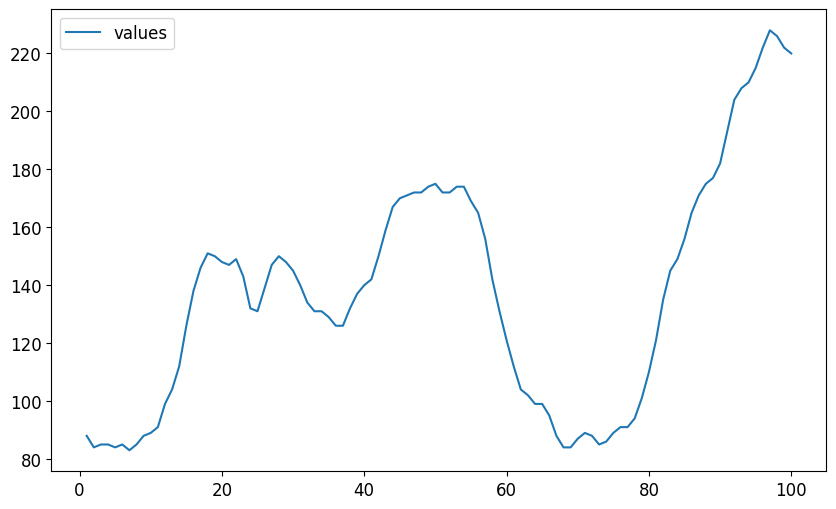

In [69]:
data.plot(figsize=(10,6))

Podemos notar que esta serie muy posiblemente no es estacionaria, por lo cual se comprobará haciendo un ADFuller test.

In [70]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [71]:
adf_test(data)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


Se comprueba que no es estacionaria, por lo que será necesario diferenciar la serie.

In [72]:
# Para este caso haremos una diferenciación de primer y segundo orden

diff1_values = data.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = data.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -9.929762e+00
p-value                        2.843429e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Stationary


Vemos que se cumple el ser estacionaria para la serie con la derivada de segundo orden.

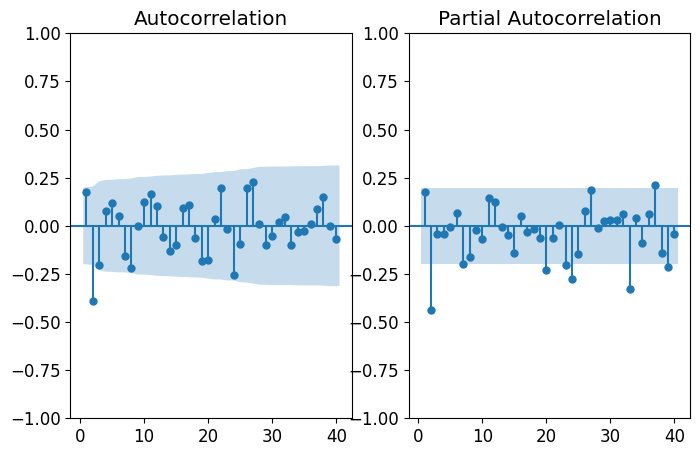

In [73]:
# Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(diff2_values, {'lags':40})

Parece ser que lo adecuado para esta serie sería un orden (2, 2, 2), sin embargo, veremos los resultados para valores de p y q cercanos, con el objetivo de encontrar el mejor modelo.

In [74]:
arima_model1 = ARIMA(data, order=(2, 2, 2))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -252.565
Date:                Tue, 06 Feb 2024   AIC                            515.131
Time:                        15:14:49   BIC                            528.055
Sample:                             0   HQIC                           520.358
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3722      0.244      1.526      0.127      -0.106       0.850
ar.L2         -0.3903      0.199     -1.966      0.049      -0.779      -0.001
ma.L1         -0.1374      0.256     -0.537      0.5

In [75]:
arima_model2 = ARIMA(data, order=(2, 2, 1))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -252.628
Date:                Tue, 06 Feb 2024   AIC                            513.256
Time:                        15:14:49   BIC                            523.596
Sample:                             0   HQIC                           517.438
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3513      0.236      1.488      0.137      -0.111       0.814
ar.L2         -0.4572      0.097     -4.729      0.000      -0.647      -0.268
ma.L1         -0.1162      0.254     -0.457      0.6

In [76]:
arima_model3 = ARIMA(data, order=(2, 2, 0))
model3 = arima_model3.fit()
print(model3.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -252.732
Date:                Tue, 06 Feb 2024   AIC                            511.465
Time:                        15:14:49   BIC                            519.220
Sample:                             0   HQIC                           514.601
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2579      0.103      2.510      0.012       0.056       0.459
ar.L2         -0.4407      0.087     -5.093      0.000      -0.610      -0.271
sigma2        10.1268      1.519      6.668      0.0

In [77]:
arima_model4 = ARIMA(data, order=(1, 2, 2))
model4 = arima_model4.fit()
print(model4.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -252.594
Date:                Tue, 06 Feb 2024   AIC                            513.189
Time:                        15:14:50   BIC                            523.529
Sample:                             0   HQIC                           517.371
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6530      0.103      6.360      0.000       0.452       0.854
ma.L1         -0.4745      3.255     -0.146      0.884      -6.855       5.906
ma.L2         -0.5251      1.688     -0.311      0.7

In [78]:
# Obtener las métricas de los modelos
metrics_data = {
    'Modelo': ['arima_model1', 'arima_model2', 'arima_model3', 'arima_model4'],
    'Log Likelihood': [model1.llf, model2.llf, model3.llf, model4.llf],
    'AIC': [model1.aic, model2.aic, model3.aic, model4.aic],
    'BIC': [model1.bic, model2.bic, model3.bic, model4.bic]
}

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(metrics_data)

print(metrics_df)

         Modelo  Log Likelihood         AIC         BIC
0  arima_model1     -252.565274  515.130547  528.055385
1  arima_model2     -252.627966  513.255933  523.595803
2  arima_model3     -252.732392  511.464783  519.219686
3  arima_model4     -252.594423  513.188846  523.528716


Considerando que los valores de Log-Likelihood son muy similares en los 4 modelos, me baso en el AIC y BIC para determinar que para esta serie el mejor modelo sería el arima_model3 que es de orden (2, 2, 0).

2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.

In [79]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)
data_normalized

array([[0.03448276],
       [0.00689655],
       [0.0137931 ],
       [0.0137931 ],
       [0.00689655],
       [0.0137931 ],
       [0.        ],
       [0.0137931 ],
       [0.03448276],
       [0.04137931],
       [0.05517241],
       [0.11034483],
       [0.14482759],
       [0.2       ],
       [0.29655172],
       [0.37931034],
       [0.43448276],
       [0.46896552],
       [0.46206897],
       [0.44827586],
       [0.44137931],
       [0.45517241],
       [0.4137931 ],
       [0.33793103],
       [0.33103448],
       [0.3862069 ],
       [0.44137931],
       [0.46206897],
       [0.44827586],
       [0.42758621],
       [0.39310345],
       [0.35172414],
       [0.33103448],
       [0.33103448],
       [0.31724138],
       [0.29655172],
       [0.29655172],
       [0.33793103],
       [0.37241379],
       [0.39310345],
       [0.40689655],
       [0.46206897],
       [0.52413793],
       [0.57931034],
       [0.6       ],
       [0.60689655],
       [0.6137931 ],
       [0.613

In [80]:
n_data = pd.DataFrame(data_normalized, columns=data.columns)
n_data

,values
0,0.034483
1,0.006897
2,0.013793
3,0.013793
4,0.006897
...,...
95,0.958621
96,1.000000
97,0.986207
98,0.958621


Repetimos todo el proceso, pero ahora con los datos normalizados.

In [81]:
adf_test(n_data)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


In [82]:
n_diff1_values = n_data.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(n_diff1_values)

n_diff2_values = n_data.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(n_diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -9.929762e+00
p-value                        2.843429e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Stationary


Notamos que sucede la misma situación que con los datos sin normalizar.

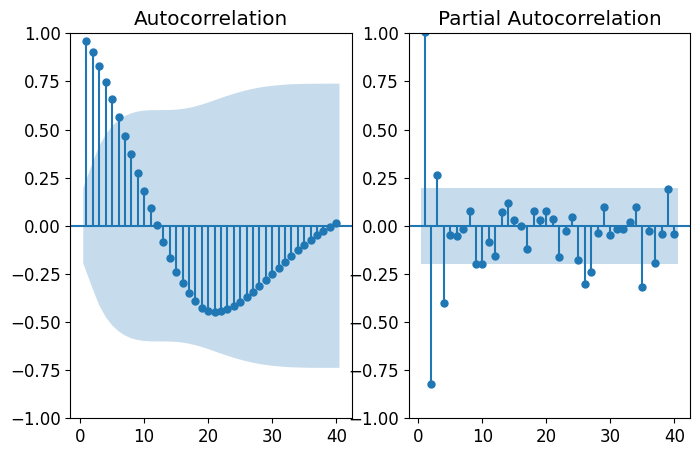

In [83]:
# Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(n_data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(n_data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(n_diff2_values, {'lags':40})

Analizando los gráfico notamos que la primera g´rafica se asemeja a una exponencial, por lo cual, no tenemos factor de Moving Average, mientras que en la autocorrelación podríamos intentar con un 4. De esta manera, el mejor modelo podría ser un (4, 2, 0).

In [84]:
n_arima_model1 = ARIMA(n_data, order=(4, 2, 0))
n_model1 = n_arima_model1.fit()
print(n_model1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(4, 2, 0)   Log Likelihood                 235.148
Date:                Tue, 06 Feb 2024   AIC                           -460.297
Time:                        15:14:51   BIC                           -447.372
Sample:                             0   HQIC                          -455.069
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2328      0.111      2.104      0.035       0.016       0.450
ar.L2         -0.4490      0.097     -4.644      0.000      -0.639      -0.260
ar.L3         -0.0379      0.113     -0.336      0.7

Considerando estos resultados con los anteriores, parece ser una excelente idea haber normalizado los datos.

Haciendo más pruebas...

In [85]:
n_arima_model2 = ARIMA(n_data, order=(2, 2, 0))
n_model2 = n_arima_model2.fit()
print(n_model2.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 234.987
Date:                Tue, 06 Feb 2024   AIC                           -463.974
Time:                        15:14:51   BIC                           -456.219
Sample:                             0   HQIC                          -460.837
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2610      0.103      2.535      0.011       0.059       0.463
ar.L2         -0.4398      0.087     -5.082      0.000      -0.609      -0.270
sigma2         0.0005   7.22e-05      6.670      0.0

In [86]:
n_arima_model3 = ARIMA(n_data, order=(1, 2, 1))
n_model3 = n_arima_model3.fit()
print(n_model3.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 228.924
Date:                Tue, 06 Feb 2024   AIC                           -451.848
Time:                        15:14:51   BIC                           -444.093
Sample:                             0   HQIC                          -448.711
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2670      0.215     -1.244      0.214      -0.688       0.154
ma.L1          0.6149      0.168      3.651      0.000       0.285       0.945
sigma2         0.0005   7.92e-05      6.901      0.0

In [87]:
n_arima_model4 = ARIMA(n_data, order=(0, 2, 0))
n_model4 = n_arima_model4.fit()
print(n_model4.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(0, 2, 0)   Log Likelihood                 222.981
Date:                Tue, 06 Feb 2024   AIC                           -443.963
Time:                        15:14:51   BIC                           -441.378
Sample:                             0   HQIC                          -442.917
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0006   9.27e-05      6.670      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   3.04   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.08   Pr

In [88]:
# Obtener las métricas de los modelos
n_metrics_data = {
    'Modelo': ['n_arima_model1', 'n_arima_model2', 'n_arima_model3', 'n_arima_model4'],
    'Log Likelihood': [n_model1.llf, n_model2.llf, n_model3.llf, n_model4.llf],
    'AIC': [n_model1.aic, n_model2.aic, n_model3.aic, n_model4.aic],
    'BIC': [n_model1.bic, n_model2.bic, n_model3.bic, n_model4.bic]
}

# Crear un DataFrame con las métricas
n_metrics_df = pd.DataFrame(n_metrics_data)

print(n_metrics_df)

           Modelo  Log Likelihood         AIC         BIC
0  n_arima_model1      235.148413 -460.296825 -447.371988
1  n_arima_model2      234.986947 -463.973894 -456.218991
2  n_arima_model3      228.923850 -451.847700 -444.092798
3  n_arima_model4      222.981411 -443.962823 -441.377855


Considerando los resultados anteriores, el n_arima_model4 resulta ser el de mejores métricas (ARIMA (0, 2, 0)), siendo bastante mejor que los modelos ARIMA con datos sin normalizar.

3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad.

Investigación SARIMAX:

SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) es una versión actualizada del modelo ARIMA. Mientras que ARIMA incluye un modelo autorregresivo integrado de media móvil, SARIMAX incorpora efectos estacionales y factores exógenos junto con el componente autorregresivo y de media móvil en el modelo. Por lo tanto, podemos decir que SARIMAX es un modelo equivalente estacional, al igual que SARIMA y Auto ARIMA.

Otro modelo equivalente estacional mantiene el patrón estacional; también puede manejar efectos externos. Esta característica del modelo difiere de otros modelos.

En los parámetros de los modelos SARIMAX, necesitamos proporcionar dos tipos de órdenes. La primera es similar al modelo ARIMAX (p, d, q), y la otra es especificar el efecto de la estacionalidad; llamamos a este orden un orden estacional, en el cual debemos proporcionar cuatro números: Especificación AR estacional, Orden de integración estacional, MA estacional, Periodicidad estacional.

Fuente: https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

In [89]:
import pandas as pd
from datetime import datetime
import requests
from io import BytesIO

air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2['time'] = data2['time'].apply(lambda x: datetime(int(x), 1, 1))
data2.index = pd.date_range(start=data2['time'][0], periods=len(data2), freq='MS')
data2 = data2.drop('time', axis=1)
data2

,air,t
1949-01-01,112,1.0
1949-02-01,118,2.0
1949-03-01,132,3.0
1949-04-01,129,4.0
1949-05-01,121,5.0
...,...,...
1960-08-01,606,140.0
1960-09-01,508,141.0
1960-10-01,461,142.0
1960-11-01,390,143.0


In [90]:
data2.drop(columns='t')

,air
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


<Axes: title={'center': 'Air Plot'}>

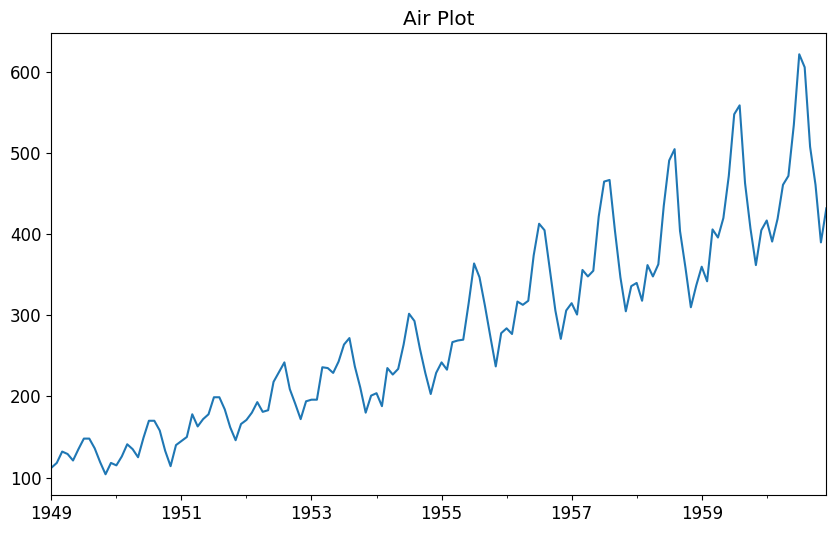

In [91]:
data2['air'].plot(figsize=(10, 6), title='Air Plot')

Notamos que la serie tiene una clara tendencia y estacionalidad. Aunque ya que para esta serie se utilizará un modelo SARIMAX no será necesario diferenciarla.

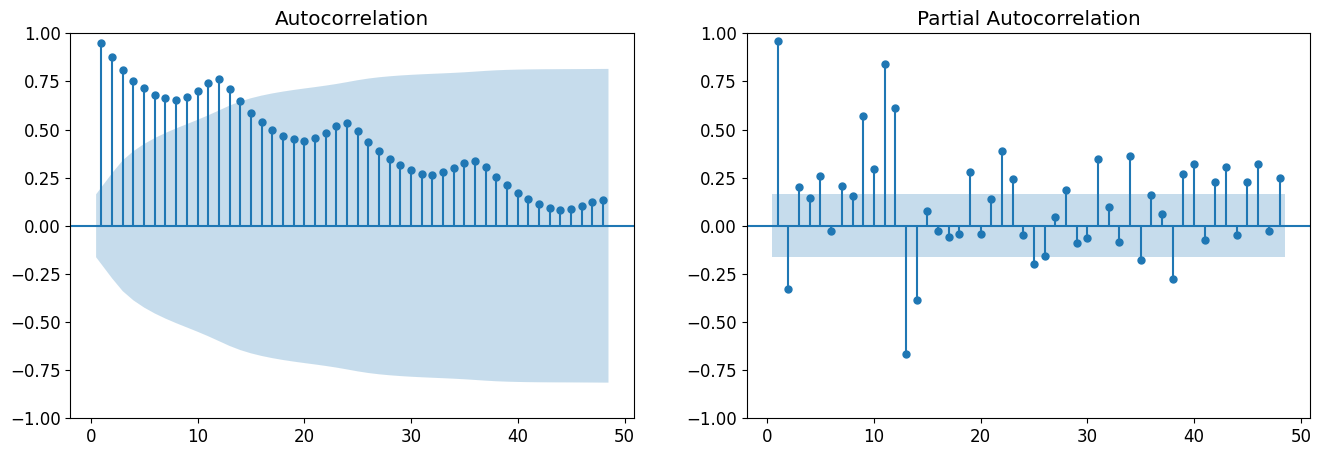

In [92]:
# Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(16,5))

    ax1 = f.add_subplot(121)

    plot_acf(data2['air'], zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data2['air'], zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(data2['air'], {'lags':48})

De la gráfica de PACF podemos notar que existen una estacionalidad importante cada 12 periodos (cada año).

Para hacer de manera más eficiente la selección de valores para el SARIMAX, se tomarán rangos de estos valores buscando los mejores parámetros para el modelo, tomando como referencia el Criterio de Información de Akaike.

In [93]:
import itertools

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
S = [12]

# Generar todas las combinaciones posibles de parámetros
param_combinations = list(itertools.product(p, d, q, P, D, Q, S))

best_aic = float("inf")
best_params = None

for param in param_combinations:
    try:
        model = sm.tsa.statespace.SARIMAX(data2['air'], order=(param[0], param[1], param[2]),
                                           seasonal_order=(param[3], param[4], param[5], param[6]))
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_params = param
    except:
        continue

print("Mejores parámetros:", best_params)


Mejores parámetros: (0, 1, 1, 1, 1, 1, 12)


In [102]:
import statsmodels.api as sm
sarima_model = sm.tsa.statespace.SARIMAX(data2['air'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
results_sarima = sarima_model.fit()
print(results_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                air   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.164
Date:                            Tue, 06 Feb 2024   AIC                           1020.327
Time:                                    15:17:03   BIC                           1031.828
Sample:                                01-01-1949   HQIC                          1025.001
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3441      0.073     -4.701      0.000      -0.487      -0.201
ar.S.L12      -0.9382      0.206   

4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos.

### Predicción modelo ARIMA

<Axes: >

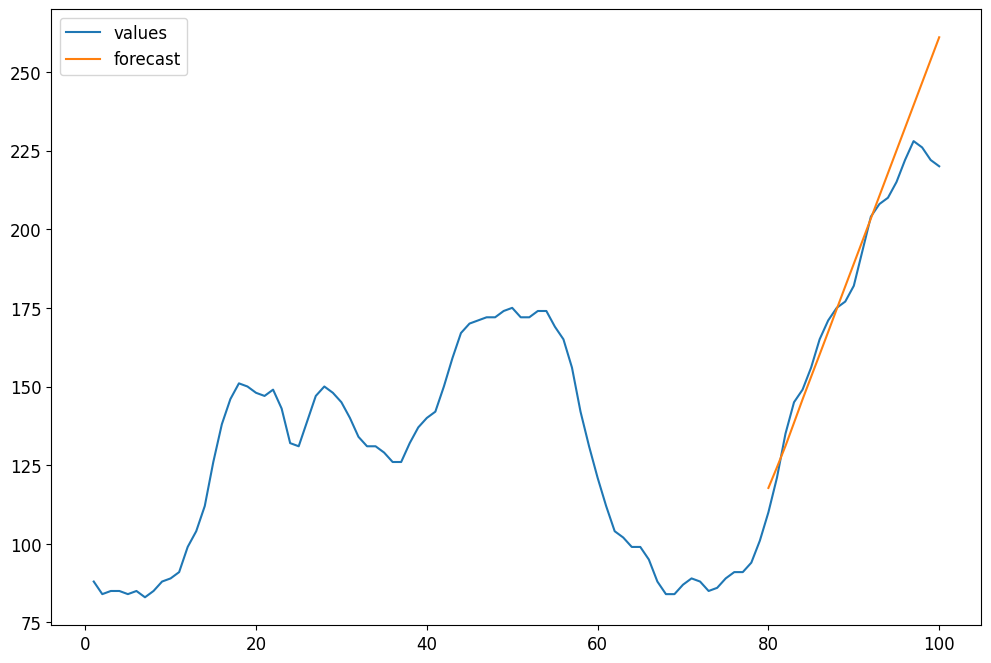

In [97]:
#Predicción con el mejor modelo ARIMA
data['forecast'] = model3.predict(start=80,end=100,dynamic=True)
data[['values','forecast']].plot(figsize=(12,8))

### Predicción modelo SARIMA

<Axes: >

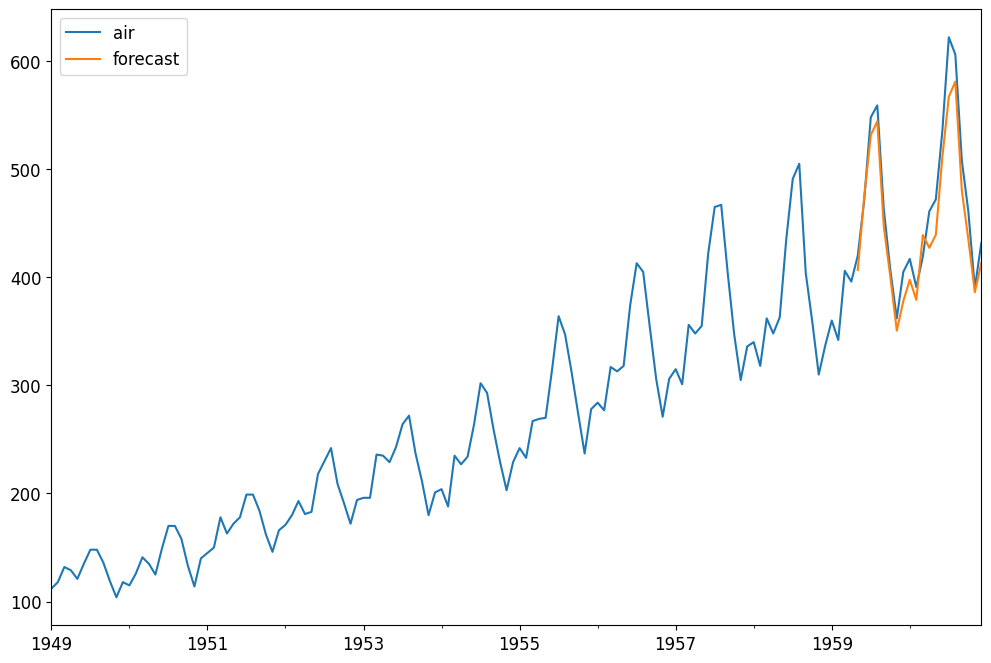

In [103]:
#Predicción con el mejor modelo SARIMA
data2['forecast']=results_sarima.predict(start=124,end=144,dynamic=True)
data2[['air','forecast']].plot(figsize=(12,8))

### Solución estudiante 2: Flavio Herrada